## Problem Set 4: Binary Dependent Variables: The Effect of Medical Spending on Infant Mortality

**Harvard University**<br/>
**Spring 2023**<br/>
**Instructor**: Gregory Bruich, Ph.D.

- Posted on: 02/14/2023
- Due at: 11:59pm on 02/21/2023


<hr style="height:2.4pt">

### Suggested Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from stargazer.stargazer import Stargazer
from scipy.stats import binned_statistic, norm

In [2]:
# These functions are used to find the standard errors of the predicted probabilities
# from logit and probit functions. They are built using the delta method, but it is
# not necessary to undertand exactly how they work. You just need to use the
# find_se function yourself.
def find_se(res, method):
    # Collect coefficient estimates from model
    a0 = res.params[0]
    a1 = res.params[1]

    # Calculate gradient of difference of functions (either logit or probit) at
    # the correct values
    if method == "probit":
        gradient = np.array([norm.pdf(a0 + a1) - norm.pdf(a0), norm.pdf(a0 + a1)])
    elif method == "logit":
        gradient = np.array(
            [
                np.exp(a0 + a1) / (np.exp(a0 + a1) + 1) ** 2
                - np.exp(a0) / (np.exp(a0) + 1) ** 2,
                np.exp(a0 + a1) / (np.exp(a0 + a1) + 1) ** 2,
            ]
        )

    # Access just the first two rows and columns of the covariance matrix
    cov_matrix = res.cov_params().to_numpy()[:, [0, 1]][[0, 1], :]

    # Calculate variance and return standard error
    variance = gradient.T @ cov_matrix @ gradient
    return variance**0.5

### Background

Low birthweight is associated with many health complications. Babies that are born weighing less than 1,500 grams (just under 3 pounds, 5 ounces) are clinically classified as “very low birth weight” (VLBW). Clinical problems associated with VLBW include hypothermia, hypoglycemia, perinatal asphyxia, respiratory problems, fluid and electrolyte imbalances, hyperbilirubinemia, anemia, impaired nutrition, infection, neurological problems, ophthalmologic complications, and sudden infant death syndrome (SIDS).

Because [neonatal intensive care](https://www.massgeneral.org/children/neonatology) has been shown to reduce mortality among infants with VLBW,
current standards call for neonatal intensive-care for all infants clinically classified as VLBW. VLBW newborns stay in the hospital longer and undergo more procedures and diagnostic tests. The higher intensity of care results in $4,553 higher hospital charges for babies born just below the 1,500 g birthweight threshold compared with those just above the threshold (Figure 1 below).

In this problem set, you will estimate the effect of this additional healthcare spending shown in Figure 1 on an important health outcome: infant mortality. The main outcome variable of interest is a dummy variable for whether the infant died within one year. Because this dependent variable is binary, you will present estimates of this causal effect using linear probability models, probit models, and logit models.

**Figure 1: Hospital Charges (in dollars) by Birth Weight (in grams)**

![figure1](images/figure1.png)


<hr style="height:2.4pt">


### Data Description
**File**: `infantmortality.dta`

The data consist of information reported on birth certificates for $n = 194,803$ births. These data were linked to information reported on death certificates for infants who die within one year of birth (Almond, Doyle, Kowalski, and Williams 2010). The sample is restricted to observations with birthweights between 1,415 g and 1,585 g.

**Table 1: Definitions of Selected Variables in `infantmortality.dta`**

| **Variable** | **Definition**                                                                                                                                                                                                                                     | **Units**                    | **Mean** |
| ------------ | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------------- | -------- |
| `gestat`     | Gestational age in weeks.  Gestational age is the term used during pregnancy to describe how far  along the pregnancy is. A normal pregnancy can range from 38 to 42 weeks. Infants born before 37 weeks are clinically classified as “premature.” | Weeks                        | 32.2     |
| `birwt`      | Birth weight in grams.  Births with weights below 1,500 grams are clinically classified as “very low birth weight” (VLBW).                                                                                                                         | Grams (g)                    | 1494.8   |
| `death1year` | Indicator for infant mortality <br />= 1 if death occurred in less than 1 year<br />= 0 otherwise  | Binary/categorical, 0 or 1 | 0.0567   |

*Notes:* Table defines and reports means of the variables included in the dataset.


<hr style="height:2.4pt">

### Data Load

In [3]:
# Read dataset into a pandas dataframe
data = pd.read_stata("infantmortality.dta")

# Display first 5 rows of data
data.head()

,gestat,birwt,death1year
0,36,1503,0.0
1,27,1503,0.0
2,30,1503,0.0
3,30,1503,0.0
4,36,1503,0.0


<hr style="height:2.4pt">

### Instructions

Please submit your Problem Set on Canvas. Your submission should include two files:
1. This notebook as a `.ipynb` file with your code and answers to questions
2. A `.pdf` version of this notebook

<hr style="height:2.4pt">

### Questions

*Note: Short answers should be very succinct. Show your work and intuition clearly: credit is given for explanations and not just having the correct answer*

### 1

Produce your own tables using stargazer corresponding to Table 3 with all the entries filled in. (The goal here is to save you time and improve your quality of life; if you cannot figure out how to get the predicted probabilities into the table, it is fine to put them in their own separate table.) Hint: you must generate the dummy variable for $birwt \geq 1500$ yourself. See code below

In [59]:
# First we need to create the dummy variable for birwt >= 1500
data['birwt_above_1500'] = data['birwt'].apply(lambda x: 1 if x >= 1500 else 0)
# data['birwt_above_1500'] = (data.birwt >=1500).astype(int)
# data['birwt>=1500'].value_counts()
print('We find 103047 Observations of babies who weigh above or equal to 1500g and 91756 that weigh less then 1500g.')

We find 103047 Observations of babies who weigh above or equal to 1500g and 91756 that weigh less then 1500g.


In [60]:
# create dataframe with data we want to predict:
cases = pd.DataFrame({
    'birwt>=1500': [0],
})
# use result to predict based on dataframe
# predictions = res.predict(cases[“xvar1”, “xvar2”])

In [71]:
# Your Code Here
lm = sm.ols('death1year ~ birwt_above_1500', data=data)
res_lm = lm.fit(cov_type='HC2', disp=0)
# print(res_lm.params)
# cases = pd.DataFrame(cases['birwt>=1500'])
prob_non = res_lm.predict({'birwt_above_1500': [1]})
prob_below = res_lm.predict({'birwt_above_1500': [0]})
dif_lm = float(prob_below - prob_non)

probit = sm.probit('death1year ~ birwt_above_1500', data=data)
res_probit = probit.fit(cov_type='HC2', disp=0)
prob_pro_non = res_probit.predict({'birwt_above_1500': [1]})
prob_pro_below = res_probit.predict({'birwt_above_1500': [0]})
dif_pro = float(prob_pro_below - prob_pro_non)

logit = sm.logit('death1year ~ birwt_above_1500', data=data)
res_logit = logit.fit(cov_type='HC2', disp=0)
dif_logit = (res_probit.params[1] + res_probit.params[0]) - res_probit.params[1]
prob_log_non = res_probit.predict({'birwt_above_1500': [1]})
prob_log_below = res_probit.predict({'birwt_above_1500': [0]})
dif_log = float(prob_log_below - prob_log_non)

models = [res_lm, res_probit, res_logit]
table = Stargazer(models=models)
table.custom_columns(['OLS', 'Probit', 'Logit'], [1, 1, 1])
table.add_line('Non-VLBW (birwt>=1500g)', [float(prob_non), float(prob_pro_non), float(prob_log_non)])
table.add_line('VLBW (birwt<1500g)', [float(prob_below), float(prob_pro_below), float(prob_log_below)])
table.add_line('Difference(Non-VLBW - VLBW)',[dif_lm, dif_pro, dif_log])
# table.add_line('Difference',[dif_lm, dif_pro, dif_logit],)
table.add_custom_notes(["The Standard errors reported in parentheses are heteroskedasticity robust (HC2)."])
table

<hr style="height:2.4pt">

### 2

Interpret the intercept in the regression in column 1 of Table 3 in words.

The OLS regression predicts that the probability of dying for a baby that weighs above or equal to 1500g is 0.0543 and for a baby that weighs less then 1500g the probability is 0.0595.

<hr style="height:2.4pt">

### 3
Based on column 1 of Table 3, what is the difference between the overall mortality rate for
VLBW and non-VLBW births? Which group has a higher overall mortality rate?

In [11]:
res_lm.params

Intercept                0.059506
birwt >= 1500[T.True]   -0.005210
dtype: float64

VLBW babies have a higher mortality rate, since all coeffiecients of birthweight being greater then 1500g result in a lower probability of death.

<hr style="height:2.4pt">

### 4
Consider columns 1, 2, and 3 of Table 3. Do the predicted effects and predicted
probabilities of death differ depending on which column is used to calculate them? (A
“Yes they differ” or “No they are exactly the same” would suffice. You can save your
explanation of why for question 8.)

No they are exactly the same.

<hr style="height:2.4pt">

### 5

My goal is to estimate the causal effect of the additional treatment and spending that very low birthweight infants receive (shown in Figure 1). I want to know whether the extra spending (shown to the left of the line in the graph) actually improves health outcomes.

One way to try to answer this question is simply to compare mortality rates for VLBW infants (who receive the extra spending) with non-VLBW infants (who do not receive the extra spending). That comparison is what columns 1, 2, and 3 of Table 3 measure. 

However, this contrast is not likely to measure the causal effect that I am interested in. Provide an example of an omitted variable to illustrate the problem. Use the omitted variable bias formula and your knowledge of the world to infer the signs of the inputs, concluding with an assessment of how the differences in columns 1, 2, and 3 of Table 3 relate to the causal effect I am interested in.

Isn't the casaul inference we are interested in the difference between VLBW infants who receive extra spending and those VLBW infants that don't receive extra spending?

Ideas:
- medical facilities
- nutrition levels
- geostat

<hr style="height:2.4pt">

### 6

Produce your own tables using stargazer corresponding to Table 4 with all the entries filled in. (The goal here is to save you time and improve
your quality of life; if you cannot figure out how to get the predicted probabilities into the table, it is fine to put them in their own separate table.)

You’ll have to generate new variables that equal $birwt-1500$, $(birwt-1500)^2$, and the interaction between these variables and the dummy variable for $birwt \geq 1500$.

Unlike Table 3, here I ask for standard errors for the differences in predicted probabilities in the last row of the table. For columns 3-6, use `nlcom` or `deltamethod` to calculate standard errors for the differences in predicted probabilities.

In [72]:
data

,gestat,birwt,death1year,birwt>=1500,birwt_1500,birwt_1500_squared,birwt_above_1500
0,36,1503,0.0,1,3,9,1
1,27,1503,0.0,1,3,9,1
2,30,1503,0.0,1,3,9,1
3,30,1503,0.0,1,3,9,1
4,36,1503,0.0,1,3,9,1
...,...,...,...,...,...,...,...
194798,33,1418,0.0,0,-82,6724,0
194799,32,1418,0.0,0,-82,6724,0
194800,34,1418,0.0,0,-82,6724,0
194801,29,1418,0.0,0,-82,6724,0


In [14]:
# Your Code Here
data['birwt_1500'] = data['birwt'].apply(lambda x: x - 1500)
data['birwt_1500_squared'] = data['birwt_1500'].apply(lambda x: np.square(x))

lm_ols_linear = sm.ols('death1year ~ birwt>=1500*birwt_1500', data=data)
res_ols_linear = lm_ols_linear.fit(cov_type='HC2', disp=0)

lm_ols_quadratic = sm.ols('death1year ~ birwt>=1500*birwt_1500 + birwt_1500_squared*birwt_1500', data=data)
res_ols_quadratic = lm_ols_quadratic.fit(cov_type='HC2', disp=0)

probit_linear = sm.probit('death1year ~ birwt>=1500*birwt_1500', data=data)
res_probit_linear = probit_linear.fit(cov_type='HC2', disp=0)

probit_quadratic = sm.probit('death1year ~ birwt>=1500*birwt_1500 + birwt_1500_squared*birwt_1500', data=data)
res_probit_quadratic = probit_quadratic.fit(cov_type='HC2', disp=0)

logit_linear = sm.logit('death1year ~ birwt>=1500*birwt_1500', data=data)
res_logit_linear = logit_linear.fit(cov_type='HC2', disp=0)

logit_quadratic = sm.logit('death1year ~ birwt>=1500*birwt_1500 + birwt_1500_squared*birwt_1500', data=data)
res_logit_quadratic = logit_quadratic.fit(cov_type='HC2', disp=0)

# Let's get the standard errors
probit_linear_se = find_se(res_probit_linear, 'probit')
probit_quadratic_se = find_se(res_probit_quadratic, 'probit')
logit_linear_se = find_se(res_logit_linear, 'logit')
logit_quadratic_se = find_se(res_logit_quadratic, 'logit')

# Let's get the standard error for OLS Linear
# var_beta_1 = (res_ols_quadratic.bse['birwt_1500'])**2
# var_beta_2 = (res_ols_quadratic.bse['birwt_1500_squared'])**2
# cov_matrix = res_ols_quadratic.cov_params()
# cov_beta_1_beta_2 = cov_matrix.birwt_1500.birwt_1500_squared

# var = var_beta_1 + (3**2) * var_beta_2 + 2*3*cov_beta_1_beta_2
# ols_quadratic_se = np.sqrt(var)

models = [res_ols_linear, res_ols_quadratic, res_probit_linear, res_probit_quadratic, res_logit_linear, res_logit_quadratic]
table_2 = Stargazer(models)
table_2.custom_columns(['OlS(Linear)', 'OLS(Quadratic)', 'Probit(Linear)', 'Probit(Quadratic)', 'Logit(Linear)', 'Logit(Quadratic)'], [1, 1, 1, 1, 1, 1])
table_2.covariate_order(['birwt >= 1500[T.True]', 'birwt_1500', 'birwt >= 1500[T.True]:birwt_1500', 'birwt_1500_squared', 'birwt_1500_squared:birwt_1500', 'Intercept'])
table_2.add_custom_notes(["The Standard errors reported in parentheses are heteroskedasticity robust (HC2)."])
table_2.add_line('Standard Errors',[0, ols_quadratic_se, probit_linear_se, probit_quadratic_se, logit_linear_se, logit_quadratic_se],)
table.significant_digits(6)
table_2

<hr style="height:2.4pt">

### 7

To give some further intuition about how we estimate the discontinuity at the threshold in a regression discontinuity design, please do the following:
- a) Estimate a regression of $death1year$ on $birwt$ using data with $birwt < 1500$. Use your regression to compute a predicted value for $death1year$ at the threshold of 1500.
- b) Estimate a regression of $death1year$ on $birwt$ using data with $birwt \geq 1500$. Use your regression to compute a predicted value for $death1year$ at the threshold of 1500.
- c) Compare the difference in (a) and (b) with the coefficient reported in column 1 of Table 4

## 7a)

In [75]:
data_below = data.loc[data['birwt'] < 1500]
data_above = data.loc[data['birwt'] >= 1500]

reg_lin_below = sm.ols('death1year ~ birwt', data=data_below)
res_lin_below = reg_lin_below.fit(cov_type='HC2', disp=0)

pred_below = res_lin_below.predict({'birwt':[1500]})
pred_below

print(f'The predicted value at the threshold of 1500 using the reg of death1year on birwt with data birwt < 1500 is: {pred_below[0]:.4f}')


The predicted value at the threshold of 1500 using the reg of death1year on birwt with data birwt < 1500 is: 0.0522


## 7b)

In [60]:
reg_lin_above = sm.ols('death1year ~ birwt', data=data_above)
res_lin_above = reg_lin_above.fit(cov_type='HC2', disp=0)

pred_above = res_lin_above.predict({'birwt':[1500]})

print(f'The predicted value at the threshold of 1500 using the reg of death1year on birwt with data birwt >= 1500 is: {pred_above[0]:.4f}')

The predicted value at the threshold of 1500 using the reg of death1year on birwt with data birwt >= 1500 is: 0.0613


## Extra
Lets visualize this to better see whats going on :)

<AxesSubplot:xlabel='birwt', ylabel='death1year'>

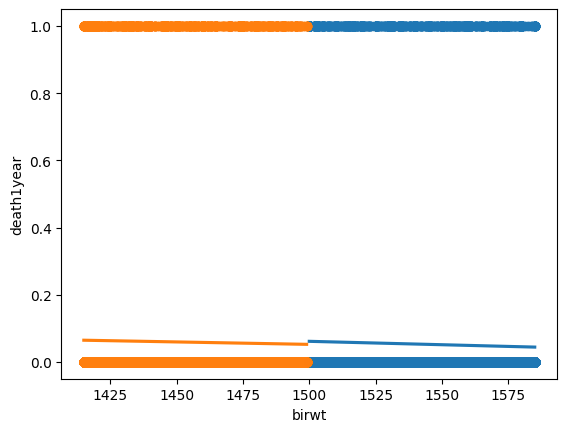

In [61]:
import seaborn as sns

sns.regplot(x='birwt', y='death1year', data=data_above)
sns.regplot(x='birwt', y='death1year', data=data_below)
plt.title('Plotted Regression lines')

## 7c)

In [63]:
table_2

In [68]:
dif = pred_above - pred_below 
print(dif)
print(res_ols_linear.params)

0    0.009096
dtype: float64
Intercept                           0.052204
birwt >= 1500[T.True]               0.009096
birwt_1500                         -0.000146
birwt >= 1500[T.True]:birwt_1500   -0.000056
dtype: float64


The difference we get is 0.009096, and the coeffiecient of birwt above or below 1500 is 0.009096

<hr style="height:2.4pt">

### 8

What do the predicted values in 7(a) and 7(b) correspond to in terms of the potential outcomes $Y_i(1)$ and $Y_i(0)$ from the Potential Outcome Framework for Causal Inference? Explain briefly. Verbal intuition is fine; you do not need to answer formally or mathematically.

7a) is the predicted probability for an infant below 1500g which we know are those that do not receive treatment, and 7b) is the predicted probability for an infant above or equal to 1500g. Hence, $Y_i(1)$ is infants below 1500g and $Y_i(0)$ is infants above or equal to 1500. Generally, $Y_i(X)$ is our framework, where $X_i$ is 1 if $i$ receives treatment, and 0 if $i$ receives control.<br>

We can formulate: $$\Delta \hat{Y}_i = E[Y_i(1)|W_i < 1500] - E[Y_i(0)|W_i \geq 1500]$$

<hr style="height:2.4pt">

### 9

The regression in column 1 of Table 4 is of the following form:

$$Y_i = \beta_0 + \beta_1nonVLBW_i + \beta_2(birwt_i - 1500) + \beta_3(birwt_i - 1500) \times nonVLBW_i + v_i$$

Consider the following modified version of this regression that replaces $birwt_i - 1500$ with $birwt_i$:
$$Y_i = \alpha_0 + \alpha_1nonVLBW_i + \alpha_2birwt_i + \alpha_3birwt_i \times nonVLBW_i + u_i$$

What is the mathematical relationship between $\beta_1$ and $\alpha_1$?

Hint: Refer to the slides from lecture on Tuesday February 14, 2023.

I think the answer to this stems from plugging in the differences in $\Delta(Y)$ at the threshold.

<hr style="height:2.4pt">

### 10

Consider the changes in the predicted probability of death at the VLBW threshold as estimated in columns 1 through 6 of Table 4. Do the predicted effects on and predicted probabilities of death differ depending on which column of the table is used to calculate them?

The predicted probabilities of death at the VLBW thresholds 

<hr style="height:2.4pt">

### 11

Briefly explain why your answers to questions 4 and 10 differ.

*[Your Answer Here]*

<hr style="height:2.4pt">

### 12

What seems to matter more: using OLS, probit vs. logit, or the order of the polynomial? (Again, your answer can be very brief)

*[Your Answer Here]*

<hr style="height:2.4pt">

### 13
Conditional mean independence is a general condition for any regression to measure a causal effect. If all other determinants of infant mortality evolve smoothly with birthweight, then the only discrete change at the threshold is the change in intensity of care, and conditional mean independence will be satisfied. Based on the variables provided to you in this data set, what evidence could you bring to bear to assess whether this assumption is plausibly satisfied in the data? What do you conclude from this supplementary evidence?

In [10]:
# Your Code Here

*[Your Answer Here]*

<hr style="height:2.4pt">

### Sample Code

shows how to add a new variable to the data frame that
equals 1 if xvar is greater than or equal to
1500 and zero otherwise.

```python
mortality[“birwt_ge_1500g”] = (mortality.xvar >=
1500).astype(int)
```

Fits probit regression
```python
mod = sm.probit(
    “yvar ~ xvar1 + xvar2”,
    data=mortality,
)
res = mod.fit(cov_type=”HC2”, disp=0)
```

Fits logit regression
```python
mod = sm.logit(
    “yvar ~ xvar1 + xvar2”,
    data=mortality,
)
res = mod.fit(cov_type=”HC2”, disp=0)
```

These commands report a predicted
probability at xvar1 = 3 and xvar2 = 5 for a
linear OR probit OR logit regression
trained on columns xvar1 and xvar2
```python
# create dataframe with data we want to predict:
cases = pd.DataFrame({
    “xvar1”: [3],
    “xvar2”: [5],
})
# use result to predict based on dataframe
predictions = res.predict(cases[“xvar1”, “xvar2”])
```

Add a custom line to a stargazer table
consisting of 4 regressions, and expand the
number of significant digits reported in the
table
```python
table.add_line(
    “leftmost cell (label)”,
    [elt1, elt2, elt3, elt4],
)
table.significant_digits(6)
```



create new variables for the
difference between an existing variable and
a constant
```python
mortality[“x_minus_10”] = mortality.x - 10
```


Shows how to create two new dataframes,
one with a subset of the rows in which xvar
is 0, and another with the subset of the
rows for which xvar = 1
```python
group_0 = mortality.loc[mortality.xvar == 0]
group_1 = mortality.loc[mortality.xvar == 1]
```

Shows how to create a binned scatterplot
with a vertical line at some point in the
graph.
```python
# Create new x and y with only binned results
x, y = binned_statistic(
    mortality.var1,
    [mortality.var1, mortality.var2],
    bins=150
).statistic
fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, s=3)

# Draw a red, vertical line at x=25
ax.axvline(x=25, color=”r”)

# Set title and axes
ax.set_title(“some title”)
ax.set_xlabel(“some label”)
ax.set_ylabel(“some label”)
```

Shows how to calculate standard errors on
differences in predictions where only one
variable and the constant are nonzero in
one prediction and only the constant is
nonzero in the other. (This is the only case
necessary in this problem set).
```python
# Call the function to get probit estimate
probit_se = find_se(res, “probit”)

# Call the function to get logit estimate
probit_se = find_se(res, “logit”)
```